In [1]:
# 偏差和方差
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()

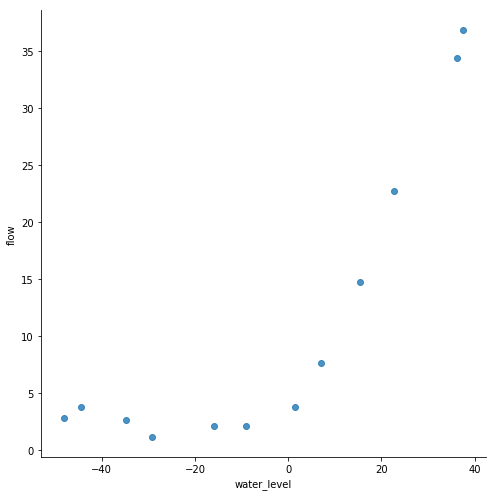

In [5]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=7)
plt.show()

In [6]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [8]:
# 代价函数
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    m = X.shape[0]
    
    inner = X @ theta - y # R(m*1)
    
    
    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)
    
    return cost

In [9]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.95152555359761

In [12]:
# 梯度
def gradient(theta, X, y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y) # (m,n).T @ (m, 1) -> (n, 1)
    return inner / m

In [13]:
gradient(theta, X, y)

array([ -15.30301567,  598.16741084])

In [16]:
# 正则化梯度
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    
    regularized_term = theta.copy()
    regularized_term[0] = 0
    
    regularized_term = (l / m) * regularized_term
    
    return gradient(theta, X, y) + regularized_term

In [17]:
regularized_gradient(theta, X, y)

array([ -15.30301567,  598.25074417])

In [24]:
# 拟合数据
def linear_regression_np(X, y, l=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """  
    #init theta
    theta = np.ones(X.shape[1])
    # train it
    res = opt.minimize(fun=regularized_cost,
                      x0=theta,
                      args=(X, y, l),
                      method='TNC',
                      jac=regularized_gradient,
                      options={'disp':True})
    return res

In [25]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0] #行
    
    regularize_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()
    
    return cost(theta, X, y) + regularize_term

In [26]:
theta = np.ones(X.shape[0])
final_theta = linear_regression_np(X, y, l=0).get('x')

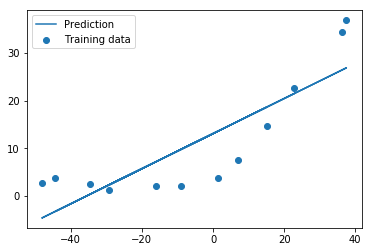

In [27]:
b = final_theta[0]
m = final_theta[1]

plt.scatter(X[:,1], y, label='Training data')
plt.plot(X[:, 1], X[:, 1] *m + b,label='Prediction')
plt.legend(loc=2)
plt.show()

In [28]:
training_cost, cv_cost = [], []

1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

In [29]:
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

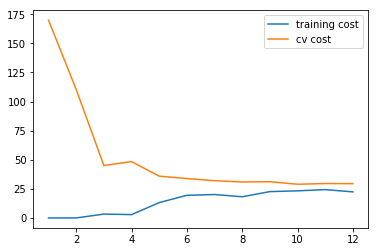

In [31]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

这个模型拟合不太好, 欠拟合了

In [32]:
# 创建多项式特征
def prepare_ploy_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)
        # normalization
        ndarr = normalize_feature(df).as_matrix()
        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    
    return [prepare(x) for x in args]

In [40]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)
    
    return df.as_matrix() if as_ndarray else df

In [41]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [42]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590
